In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential, Input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.applications import MobileNet, MobileNetV2, EfficientNetB0, NASNetMobile, VGG16, VGG19, InceptionV3, ResNet50
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score

print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.0
/device:GPU:0


**Init Config**

In [ ]:
#input dataset dir
base_dir = '/content/drive/MyDrive/your-dataset/'

#set img size, batch size, change as needed
img_size = 128
bs = 64
img_shape = (img_size, img_size, 3)

In [ ]:
#datagen to augmentation
#change as needed
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.3  # val split 30%, change as need, e.g decimal value (0.1 - 1.0)
)

In [ ]:
#data generator train
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='categorical',
    subset='training',  #set as train data
    shuffle=True
) 

#data generator val
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='categorical',
    subset='validation',  #set as val data
    shuffle=False
) 

In [ ]:
#check shape from dataset
for image_batch, labels_batch in datagen:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
#check class name from dataset
class_names = val_generator.class_indices
print(class_names)

In [ ]:
def inceptionV3():

  base_model = Sequential()
  inputs = Input((img_size, img_size, 3))
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)
  x = base_model(inputs)
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(512, activation='relu')(x)
  predictions = Dense(34, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

new_model = inceptionV3()
new_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 63, 63, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_24[0][0]']              
 alization)                                                                                       
                           

In [ ]:
#change as need, accoriding model name
models = "InceptionV3"

#output dir
filepath_acc='/content/drive/MyDrive/your-dir/' + models + '-best_acc_weights-{epoch:03d}.h5'
filepath_loss='/content/drive/MyDrive/your-dir/' + models + '-best_loss_weights-{epoch:03d}.h5'

#model checkpoint untuk menyimpan best acc/loss model
checkpoint_loss = ModelCheckpoint(filepath_loss, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
checkpoint_acc = ModelCheckpoint(filepath_acc, verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')

#decrease lr if val acc not increase
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=5, verbose=1)

#list callback
callbacks_list = [checkpoint_loss, checkpoint_acc, lr_reduce]

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.001)

new_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

**Training**

In [ ]:
%%time
#change as need
epoch = 50

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

history = new_model.fit(
        train_generator, 
        epochs=epoch, 
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps, 
        verbose=1,
        callbacks=callbacks_list,
    )

Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 3.2983 - accuracy: 0.0751 
Epoch 1: val_loss improved from inf to 9.37557, saving model to /content/drive/MyDrive/Project Penelitian/dataset/Face Recognition/output/bollywood/best-model/inception-v3-maskunmask/InceptionV3-best_loss_weights-001.h5

Epoch 1: val_accuracy improved from -inf to 0.03977, saving model to /content/drive/MyDrive/Project Penelitian/dataset/Face Recognition/output/bollywood/best-model/inception-v3-maskunmask/InceptionV3-best_acc_weights-001.h5
52/52 [==============================] - 1216s 23s/step - loss: 3.2983 - accuracy: 0.0751 - val_loss: 9.3756 - val_accuracy: 0.0398 - lr: 0.0010
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 2.6552 - accuracy: 0.1758
Epoch 2: val_loss did not improve from 9.37557

Epoch 2: val_accuracy improved from 0.03977 to 0.04474, saving model to /content/drive/MyDrive/Project Penelitian/dataset/Face Recognition/output/bollywood/best-model/incept

**Plot Figure**

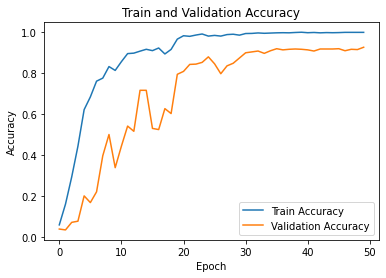

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')

plt.show()

**Testing**

In [ ]:
#change as need
file_name_model = 'InceptionV3-best_loss_weights-050.h5'

model_x = new_model
input_dir = '/content/drive/MyDrive/your-dir-model/'

model_x.load_weights(input_dir + file_name_model)

print("\nLoaded model from disk")

#evaluate loaded model on test data
adam = keras.optimizers.Adam(learning_rate=0.001)
model_x.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
eval_test = model_x.evaluate(val_generator) 

print('Test Loss: ' , '\033[1m', round(eval_test[0], 4),'\033[0m')
print('Test Acc: ' , '\033[1m', round(eval_test[1], 4),'\033[0m')


Loaded model from disk
23/23 [==============================] - 16s 573ms/step - loss: 0.3409 - accuracy: 0.9331
Test Loss:   0.3409 
Test Acc:   0.9331 


**Evaluate Model**

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

#make a prediction cvgg
y_pred_CVGG = new_model.predict(val_generator, verbose=1)

fpr = {}
tpr = {}
thresh ={}

n_class = 8

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(val_generator.classes, y_pred_CVGG[:,i], pos_label=i)

    auc_cvgg = auc(fpr[i], tpr[i])
auc_cvgg

23/23 [==============================] - 13s 517ms/step


0.999934503536809

**ROC**

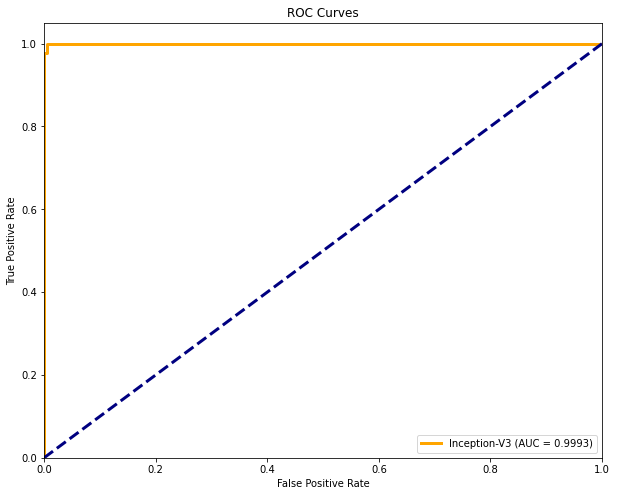

In [ ]:
plt.figure(6, figsize=(10, 8))
lw = 3
for i in range(1):
    plt.plot(fpr[i], tpr[i], color='orange',
            lw=lw, label='Inception-V3 (AUC = %0.4f)' % auc_cvgg)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="best")
    plt.show()

**Classification Report**

In [ ]:
#plotting using plot-metric
!pip install plot-metric

import plot_metric
from plot_metric.functions import MultiClassClassification

In [ ]:
#change as need, according list class name
class_names = ['Randeep Hooda', 'Rani Mukerji', 'Ranveer Singh', 'Richa Chadda', 'Riteish Deshmukh', 'Saif Ali Khan', 'Salman Khan', 'Sanjay Dutt', 'Sara Ali Khan', 'Shah Rukh Khan', 'Shahid Kapoor', 'Shilpa Shetty', 'Shraddha Kapoor', 'Shreyas Talpade', 'Shruti Haasan', 'Sidharth Malhotra', 'Sonakshi Sinha', 'Sonam Kapoor', 'Suniel Shetty', 'Sunny Deol', 'Sushant Singh Rajput', 'Taapsee Pannu', 'Tabu', 'Tamannaah Bhatia', 'Tiger Shroff', 'Tusshar Kapoor', 'Uday Chopra', 'Vaani Kapoor', 'Varun Dhawan', 'Vicky Kaushal', 'Vidya Balan', 'Vivek Oberoi', 'Yami Gautam', 'Zareen Khan']
mc = MultiClassClassification(val_generator.classes, y_pred_CVGG, labels=class_names)

mc.print_report()

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
                      precision    recall  f1-score   support

       Randeep Hooda       0.89      0.98      0.93        42
        Rani Mukerji       0.92      0.91      0.92        54
       Ranveer Singh       0.92      0.87      0.89        39
        Richa Chadda       0.96      0.96      0.96        53
    Riteish Deshmukh       0.88      0.90      0.89        40
       Saif Ali Khan       0.89      1.00      0.94        17
         Salman Khan       0.90      1.00      0.95        36
         Sanjay Dutt       0.97      0.88      0.92        33
       Sara Ali Khan       0.93      0.91      0.92        44
      Shah Rukh Khan       0.90      0.95      0.92        38
       Shahid Kapoor       0.85      0.85      0.85        34
       Shilpa Shetty       1.00      1.00      1.00        56
     Shraddha Kapoor       0.92      0.98      0.95        5

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(24, 18))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

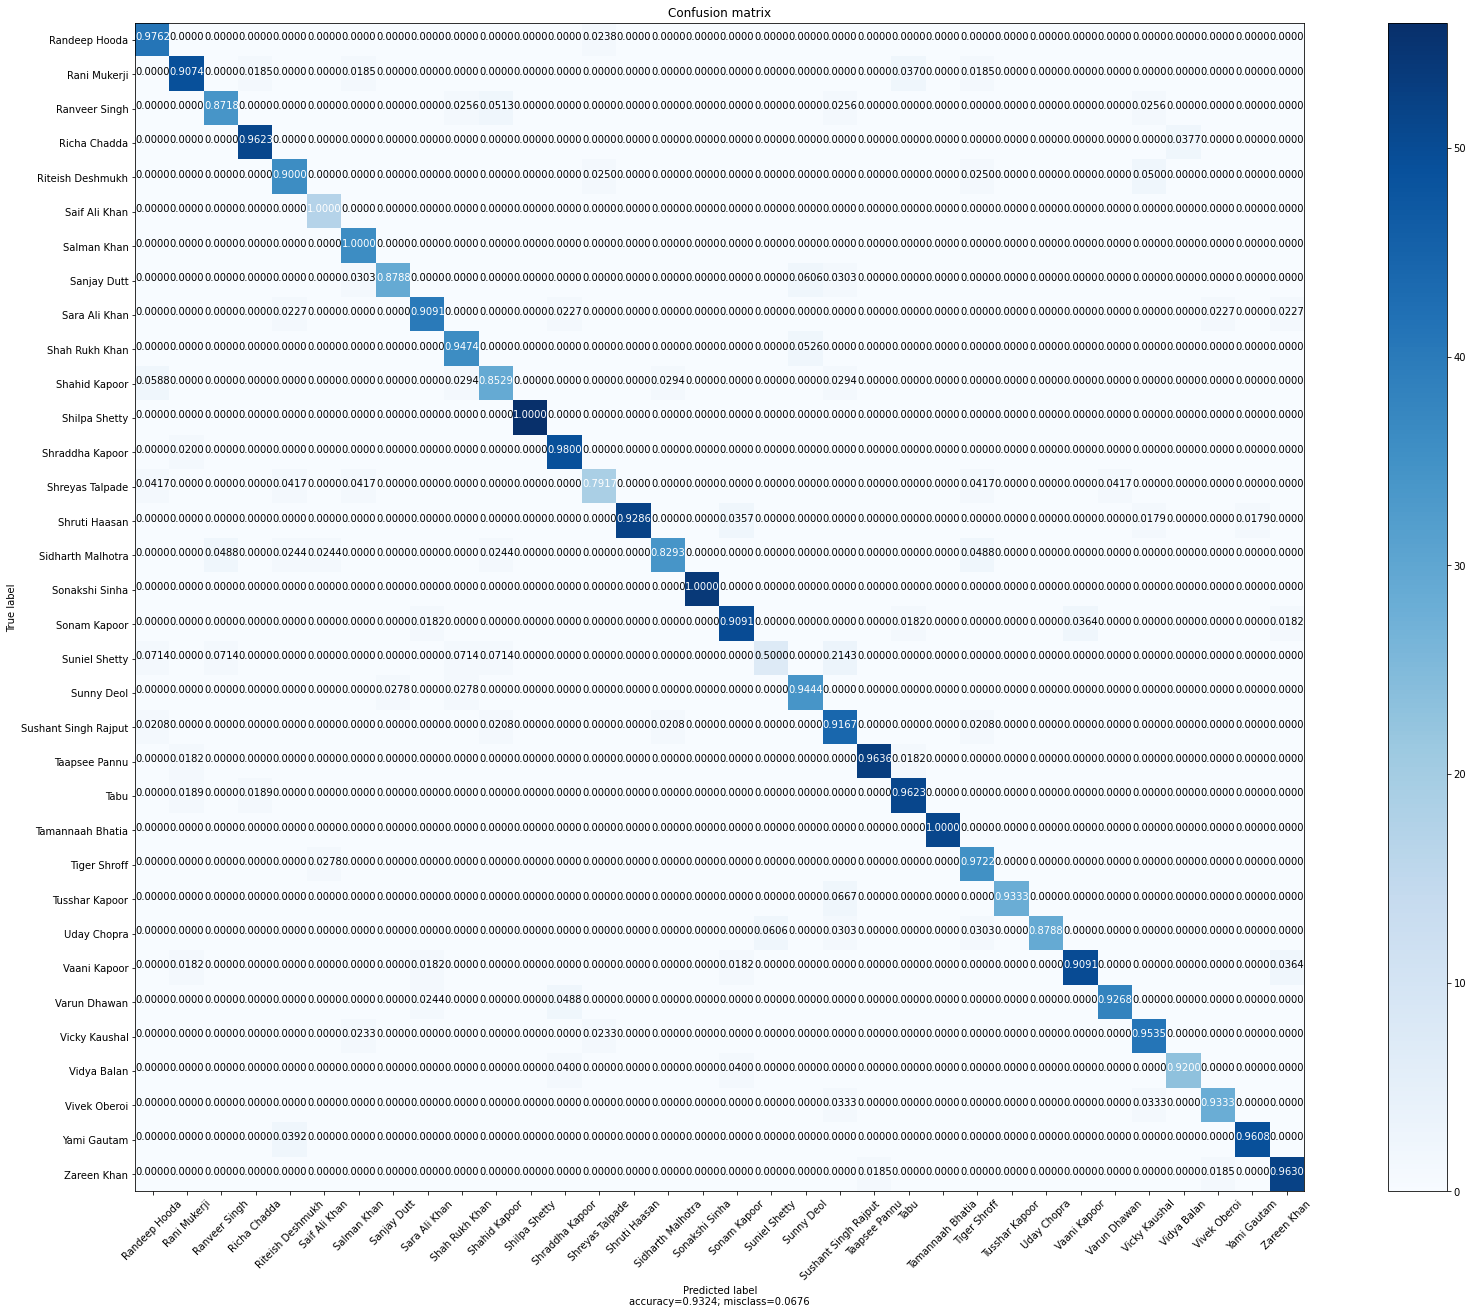

In [ ]:
cm = confusion_matrix(val_generator.classes, np.argmax(y_pred_CVGG, axis=1))

plot_confusion_matrix(cm, class_names)

**Save Model**

In [ ]:
#change as needed
models = "your-name-model"
size = "128x128"
num_epoch = 50
save_dir = '/content/drive/MyDrive/Project Penelitian/dataset/Face Recognition/output/' + models + '-weight-' + str(num_epoch) + '-epochs-' + size + '.h5'

new_model.save(save_dir)

print('Save model completed!')